In [1]:
import os, glob
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import leaves_list

In [2]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_attr = os.path.join(pth_data, 'modeling', 'interpret')
pth_feat = os.path.join(pth_data, 'features', 'biomart')
pth_out = os.path.join(pth, 'figures', 'modeling', 'attributions')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_attr, 'development.h5ad'))
adata

AnnData object with n_obs × n_vars = 143369 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 't', 'training', 'validation', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'weight_celltype', 'weight_source', 'weight', 'latent_z'
    obsm: 'X_diff', 'X_draw_gr

In [4]:
feat_fn = sorted(glob.glob(os.path.join(pth_feat, '*.csv')))
df = pd.read_csv(os.path.join(pth_data, 'summary.csv'), index_col = 0)
name = 'Neuromesodermal Progenitor'
df.loc[df.Name == name, 'Name'] = name.replace(' ', '\n')
get_source = lambda fn: os.path.split(fn)[1].replace('.csv', '')
feat_dict = {get_source(fn) : fn for fn in feat_fn if 'union' not in fn}
for src, fn in feat_dict.items():
    print(src)
    df_feat = pd.read_csv(fn)
    g = df_feat.mmusculus.copy()
    g = g.loc[g.isin(adata.var_names)]
    ig = adata[:, g].layers['IG_z'].sum(axis = 1)
    ig = np.asarray(ig).squeeze()
    adata.obs[src] = pd.qcut(ig, 100, labels = False)

EMTHallmark
GSE136689
GSE162534
GSE201257
GSE229103
HCAEmbryonicHindlimb
rRNAModifications


In [5]:
# attribution mutual information scores
ix, method = feat_dict.keys(), 'complete'
mi = pd.DataFrame(0., index = ix, columns = ix)
for key_i in mi.columns:
    for key_j in mi.columns:
        mi.loc[key_i, key_j] = mutual_info_score(
            adata.obs[key_i], adata.obs[key_j])
Z = linkage(mi, method = method, optimal_ordering = True)
mi = mi.iloc[leaves_list(Z), leaves_list(Z)].iloc[:-1, 1:]
mi.columns = df.loc[mi.columns].Name.values
mi.index = df.loc[mi.index].Name.values

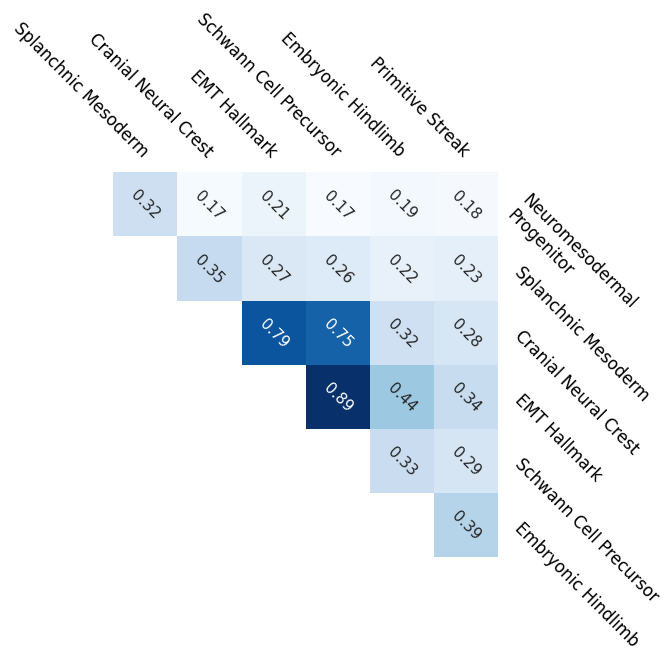

In [6]:
fs1, fs2, rot, pad = 12, 11, -45, 10
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sns.heatmap(
    mi, mask = (np.triu(mi) == 0),
    cmap = 'Blues', annot = True,
    square = True, cbar = False,
    annot_kws = {'fontsize' : fs2,
                 'rotation' : rot},
    ax = ax)

ax.set_yticklabels(ax.get_yticklabels(),
                   size = fs1, rotation = rot,
                   rotation_mode = 'anchor',
                   ha = 'left', va = 'center')
ax.set_xticklabels(ax.get_xticklabels(),
                   size = fs1, rotation = rot,
                   rotation_mode = 'anchor',
                   ha = 'right', va = 'center')
ax.tick_params('y', pad = pad,
               labelright = True,
               left = False,
               labelleft = False)
ax.tick_params('x', pad = pad,
               labeltop = True,
               bottom = False,
               labelbottom = False)
fn = os.path.join(pth_out, 'mutual_info.pdf')
plt.savefig(fn, bbox_inches = 'tight')